In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.data import GPData
from src.utils import plot_predictive
from src.model import (
    DeterministicEncoder,
    LatentEncoder,
    Decoder,
    LatentNeuralProcess
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Neural processes, step by step

The data are curves sampled from Gaussian processes with kernels of varying parameters.

In [4]:
# Sample curves from GPs with varying kernels
batch_size = 8
max_num_context = 400
data_train = GPData(
    batch_size=batch_size, 
    max_num_context=max_num_context
)
curves_train = data_train.generate_curves()

In [5]:
# Get context and targets
context_x_train = curves_train.context_x.to(device)
context_y_train = curves_train.context_y.to(device)
target_x_train = curves_train.target_x.to(device)
target_y_train = curves_train.target_y.to(device)
d_x = context_x_train.shape[2]
d_y = context_y_train.shape[2]

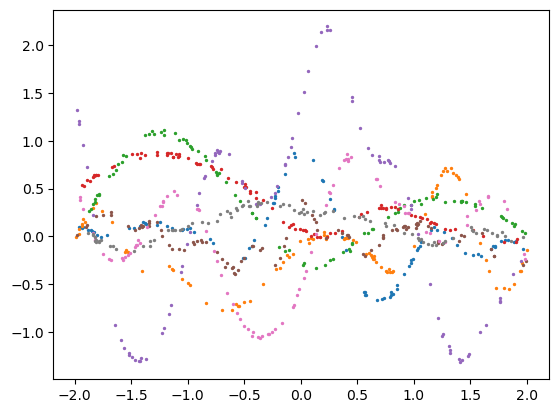

In [6]:
for i in range(batch_size):
    plt.scatter(context_x_train[i].flatten(), context_y_train[i].flatten(), s=2)
plt.show()

Context pairs take two paths in the encoding stage:
1) Deterministic path: contexts pairs are encoded to a deterministic representation
2) Latent path: context pairs are encoded into a latent code which is then sampled from

Both paths use a permutation-invariant aggregation function (e.g. mean) over context pairs for exchangeability of the neural process.

In [7]:
# Deterministic encoder
determ_enc = DeterministicEncoder(input_size=d_x+d_y, output_sizes=[128]*4)
r = determ_enc(context_x_train, context_y_train)
r.shape

torch.Size([8, 128])

In [8]:
# Latent encoder
latent_enc = LatentEncoder(input_size=d_x+d_y, output_sizes=[128]*4, num_latents=10)
prior = latent_enc(context_x_train, context_y_train)
z = prior.sample()
z.shape

torch.Size([8, 10])

The decoder takes in the deterministic and latent representations of the contexts, along with the target inputs, and returns the predictive distribution of the target outputs.

In [9]:
# Decoder
dec = Decoder(128+10+d_x, [128,128,128,2*d_y])
num_targets = target_x_train.shape[1]
r = r.unsqueeze(1).repeat(1, num_targets, 1)
z = z.unsqueeze(1).repeat(1, num_targets, 1)
dist, mu, sigma = dec(r, z, target_x_train)
mu.shape, sigma.shape

(torch.Size([8, 368, 1]), torch.Size([8, 368, 1]))

### Training

In [10]:
# Training params
n_epochs = int(1e5)
print_after = int(5e3)
plot_after = int(2e4)
train_loss = []

# Data params
batch_size = 16
max_num_context = 100

# Model params
input_dim, output_dim = 1,1
hidden_size = 128
determ_encoder_output_size = [hidden_size] * 2
latent_encoder_output_size = [hidden_size] * 2
num_latents = hidden_size
decoder_output_size = [hidden_size] * 2 + [2 * output_dim]

# Model
model = LatentNeuralProcess(
    input_dim=input_dim,
    output_dim=output_dim,
    determ_encoder_output_size=determ_encoder_output_size,
    latent_encoder_output_size=latent_encoder_output_size,
    num_latents=num_latents,
    decoder_output_size=decoder_output_size
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Iteration: 0 Training loss: 0.9777745008468628
Iteration: 5000 Training loss: 0.2778947353363037
Iteration: 10000 Training loss: 0.3873278498649597
Iteration: 15000 Training loss: -0.06379609555006027
Iteration: 20000 Training loss: 0.22323699295520782


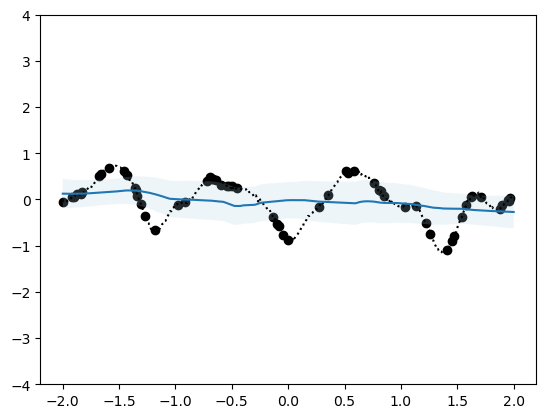

Iteration: 25000 Training loss: 0.3587510287761688
Iteration: 30000 Training loss: -0.022456340491771698
Iteration: 35000 Training loss: -0.02285630628466606
Iteration: 40000 Training loss: 0.22169767320156097


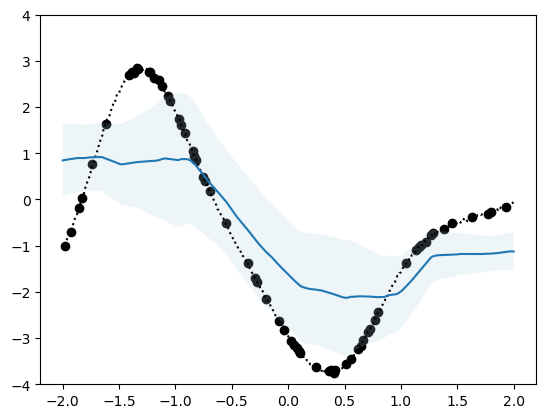

Iteration: 45000 Training loss: -0.04185326397418976
Iteration: 50000 Training loss: -0.06330054253339767
Iteration: 55000 Training loss: 0.05230139195919037
Iteration: 60000 Training loss: -0.007306767627596855


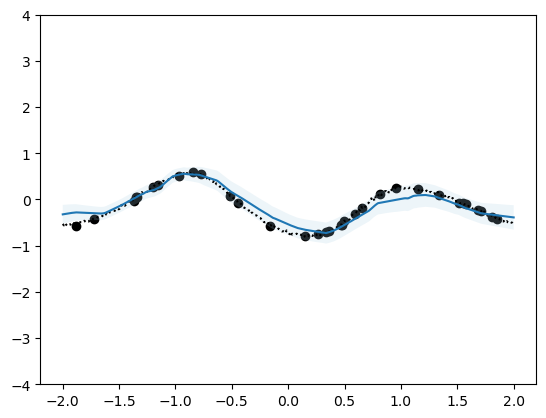

Iteration: 65000 Training loss: 0.42262768745422363
Iteration: 70000 Training loss: 0.27630817890167236
Iteration: 75000 Training loss: -0.5445144176483154
Iteration: 80000 Training loss: -0.4440091550350189


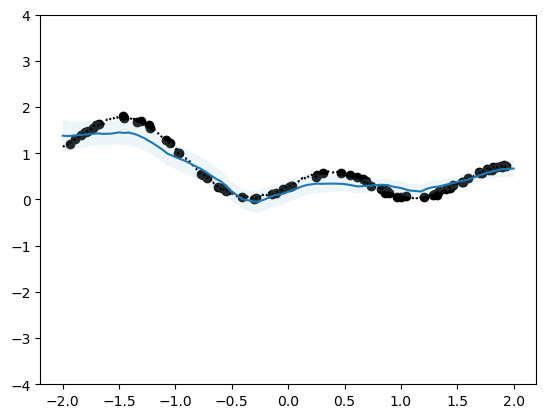

Iteration: 85000 Training loss: -0.11538814753293991
Iteration: 90000 Training loss: -0.10786235332489014
Iteration: 95000 Training loss: 0.007214449346065521
Iteration: 100000 Training loss: -0.45756497979164124


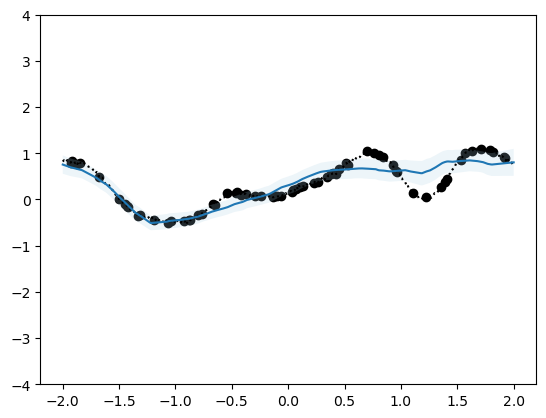

In [11]:
for it in range(n_epochs+1):
    optimizer.zero_grad()

    # Sample a batch of datasets (contexts, targets)
    data_train = GPData(
        batch_size=batch_size, max_num_context=max_num_context,)
    curves_train = data_train.generate_curves()
    context_x_train = curves_train.context_x.to(device)
    context_y_train = curves_train.context_y.to(device)
    target_x_train = curves_train.target_x.to(device)
    target_y_train = curves_train.target_y.to(device)

    # Forward
    _, _, log_prob, _, loss = model(
        context_x_train, context_y_train,
        target_x_train, target_y_train)

    # Backprop
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    if it % print_after == 0:
        print(f'Iteration: {it} Training loss: {loss.item()}')

    if it % plot_after == 0 and it > 0:
        with torch.no_grad():
            data_test = GPData(
                batch_size=1, max_num_context=max_num_context, 
                testing=True)
            curves_test = data_test.generate_curves()
            context_x_test = curves_test.context_x.to(device)
            context_y_test = curves_test.context_y.to(device)
            target_x_test = curves_test.target_x.to(device)
            target_y_test = curves_test.target_y.to(device)

            pred_y, sigma, _, _, _ = model(
                context_x_test, context_y_test, target_x_test)
            plot_predictive(
                context_x_test, context_y_test,
                target_x_test, target_y_test,
                pred_y, sigma)

In [ ]:
# Sample a curve
data = GPData(
    batch_size=1, max_num_context=max_num_context, 
    testing=True)
curves = data.generate_curves()
target_x = curves.target_x.to(device)
target_y = curves.target_y.to(device)

num_context = 150
idx = np.arange(target_x.shape[1])
np.random.shuffle(idx)

with torch.no_grad():
    for i in range(1,num_context+1):
        curr_context_x = target_x[:,idx[:i],:]
        curr_context_y = target_y[:,idx[:i],:]
        pred_y, sigma, _, _, _ = model(
            curr_context_x, curr_context_y, target_x)
        plot_predictive(
            curr_context_x, curr_context_y,
            target_x, target_y,
            pred_y, sigma, save=f'docs/{i}.png')